In [1]:
import pandas as pd

from rdkit import Chem, DataStructs
from rdkit.Chem import rdmolops, rdMolAlign
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles, Descriptors, rdchem, rdMolDescriptors, rdmolops, rdFMCS
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import Draw

from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from IPython.display import SVG,Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


This notebook provides some example code to analyse SF predictions generated with the CLI on this feature branch. We will examine:
- the distribution of predicted SFs
- the molecular structures of both the queried perturbations and the RBFE-Space derivatives
- predicted SF vs relative molecular weight

In [2]:
def alignLigands(liga, ligb):
    """Given a duo of ligands; align to the first ligand such that we can more easily view differences.
    All ligand manipulations are done in-place."""
    
    template = Chem.MolFromSmarts(rdFMCS.FindMCS([liga, ligb],
                                    atomCompare=rdFMCS.AtomCompare.CompareAny,
                                    bondCompare=rdFMCS.BondCompare.CompareAny,
                                    matchValences=False,
                                    ringMatchesRingOnly=True,
                                    completeRingsOnly=True,
                                    matchChiralTag=False,
                                    timeout=2).smartsString) # need to set timeout because for some scaffolds the MCS
                                                             # can take minutes.
    AllChem.Compute2DCoords(template)
    
    for lig in [liga, ligb]:
        # align.
        AllChem.GenerateDepictionMatching2DStructure(lig, template)
        # Remove stereochemistry to simplify depiction in network.
        rdmolops.RemoveStereochemistry(lig)
    
    return liga, ligb

In [3]:
def getMolImg(mol):
    """Saves a molecule image and loads it back in and returns it. Allows viewing RDKit molecules during 
    loop iterations. """

    Draw.MolToFile(mol, "plt_workdir/tmp.png")
    img = mpimg.imread("plt_workdir/tmp.png")
    
    return img    

In [4]:
def depictMolTriplet(liga, ligb, ligc, ligd, pert_name):
    """given four molecular inputs, plot a graph of each, side-by-side."""
    
    # get img objects for each lig
    img0 = getMolImg(liga)
    img1 = getMolImg(ligb)
    img2 = getMolImg(ligc)
    img3 = getMolImg(ligd)
    
    # now plot.
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

    axes[0].imshow(img0)
    axes[1].imshow(img1)
    axes[2].imshow(img2)
    axes[3].imshow(img3)

    # turn off axes and set titles.
    titles = ["$\lambda = 0$", "$\lambda = 0$ (RBFE-Space)", "$\lambda = 1$ (RBFE-Space)", "$\lambda = 1$"]
    for ax, title in zip(axes, titles):
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_title(title)

    # annotate the left-hand side plot with the perturbation name instead of y axis label.
    axes[0].text(-0.05, 0.5*(0.25+0.75), f"{pert_name}",
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=axes[0].transAxes)
    
    plt.show()

## SF distribution

In [5]:
# first load in the output file with the predictions.
output_file_df = pd.read_csv("output_example.csv")
output_file_df

,lig_1_path,lig_2_path,lig_1_smiles,lig_2_smiles,lig_1_benzene_deriv,lig_2_benzene_deriv,sf_prediction
0,input_files_example/ejm_44.sdf,input_files_example/jmc_27.sdf,CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,O=C(Nc1ccnc(NC(=O)[C@H]2C[C@H]2Cl)c1)c1c(Cl)cc...,CC(C)(C)Cc1ccccc1,ClC1CC1Cc1ccccc1,0.413468
1,input_files_example/jmc_27.sdf,input_files_example/ejm_44.sdf,O=C(Nc1ccnc(NC(=O)[C@H]2C[C@H]2Cl)c1)c1c(Cl)cc...,CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,ClC1CC1Cc1ccccc1,CC(C)(C)Cc1ccccc1,0.306752
2,input_files_example/ejm_44.sdf,input_files_example/ejm_54.sdf,CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,CCNC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,CC(C)(C)Cc1ccccc1,CCNCc1ccccc1,0.287593
3,input_files_example/ejm_54.sdf,input_files_example/ejm_44.sdf,CCNC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,CCNCc1ccccc1,CC(C)(C)Cc1ccccc1,0.244134
4,input_files_example/ejm_44.sdf,input_files_example/ejm_46.sdf,CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1c(Cl)cccc1Cl,CC(C)(C)Cc1ccccc1,c1ccc(CC2CC2)cc1,0.270483
...,...,...,...,...,...,...,...
235,input_files_example/ejm_45.sdf,input_files_example/ejm_42.sdf,O=C(CC1CC1)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,c1ccc(CC2CC2)cc1,CCc1ccccc1,0.176042
236,input_files_example/ejm_42.sdf,input_files_example/ejm_47.sdf,CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1c(Cl)cccc1Cl,CCCc1ccccc1,c1ccc(CC2CCC2)cc1,0.271642
237,input_files_example/ejm_47.sdf,input_files_example/ejm_42.sdf,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1c(Cl)cccc1Cl,CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,c1ccc(CC2CCC2)cc1,CCCc1ccccc1,0.181076
238,input_files_example/ejm_45.sdf,input_files_example/ejm_47.sdf,O=C(CC1CC1)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1c(Cl)cccc1Cl,c1ccc(CCC2CC2)cc1,c1ccc(CC2CCC2)cc1,0.309403


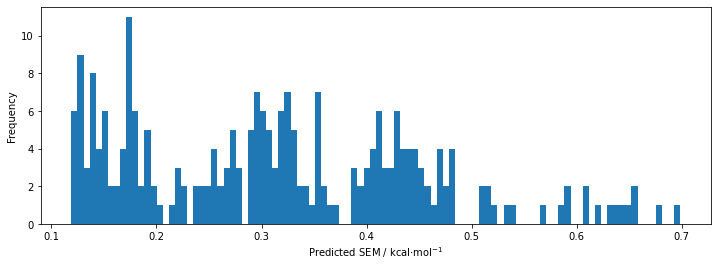

In [6]:
# use some simple plotting functions to display the SF distribution.
fig, ax = plt.subplots(figsize=(12, 4)) # easier for controlling figure dims

# make the histogram.
ax.hist(output_file_df["sf_prediction"], bins=100) # tweak n bins here.

# do some further formatting.
ax.set_xlabel("Predicted SEM / kcal$\cdot$mol$^{-1}$")
ax.set_ylabel("Frequency")


plt.show()

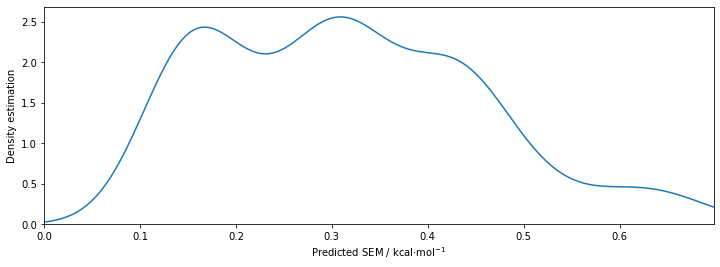

In [7]:
# we can also make it a bit prettier, e.g. using a density plot. Seaborn makes this quite straightforward. 
fig, ax = plt.subplots(figsize=(12, 4)) # easier for controlling figure dims

sns.kdeplot(output_file_df["sf_prediction"], ax=ax)

# do some further formatting.
ax.set_xlabel("Predicted SEM / kcal$\cdot$mol$^{-1}$")
ax.set_ylabel("Density estimation")

ax.set_xlim(0, max(output_file_df["sf_prediction"])) # cut off the x values; SEM < 0 is confusing.

plt.show()




## Depict transformations
Grafting onto benzene is not always succesful (especially for complex perturbations!) so it is useful to check whether this has happened correctly. If the RBFENN networks do not perform as well as expected this is a good first check. 

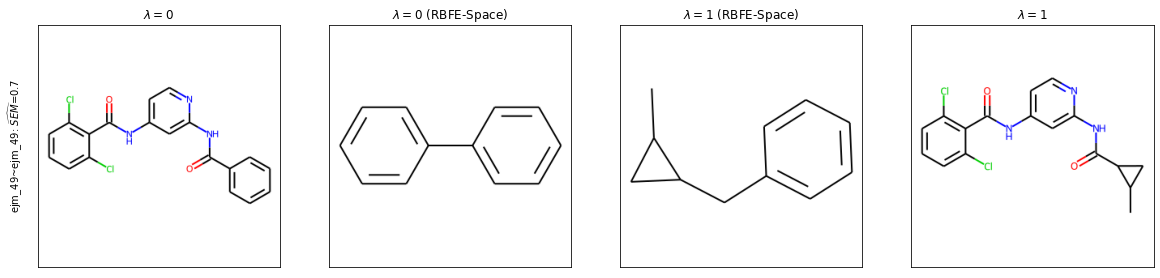

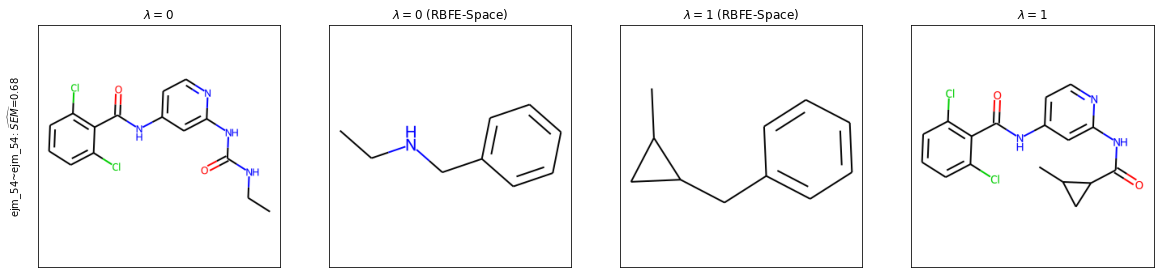

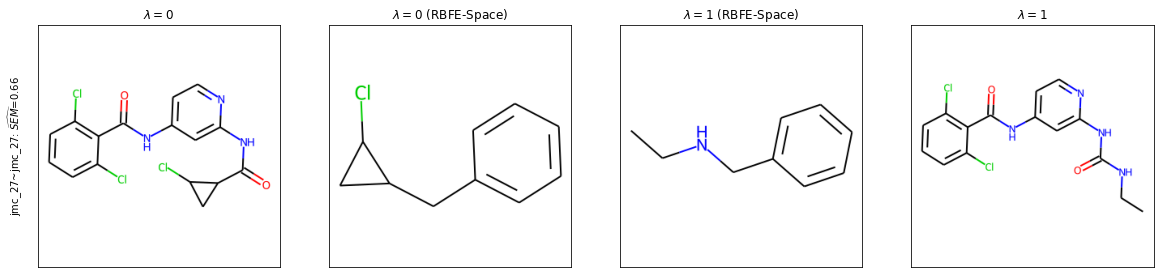

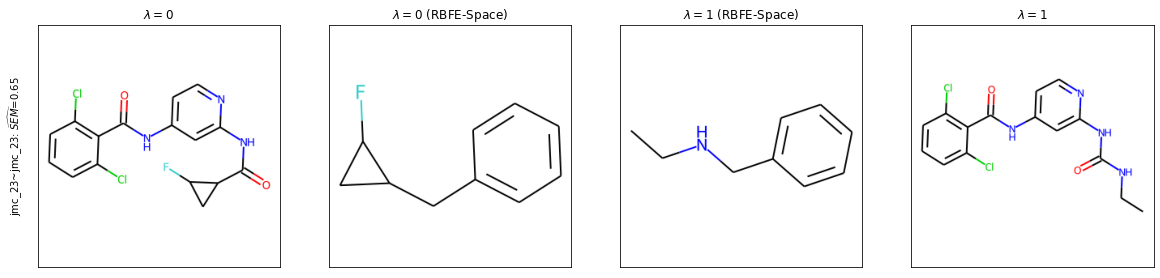

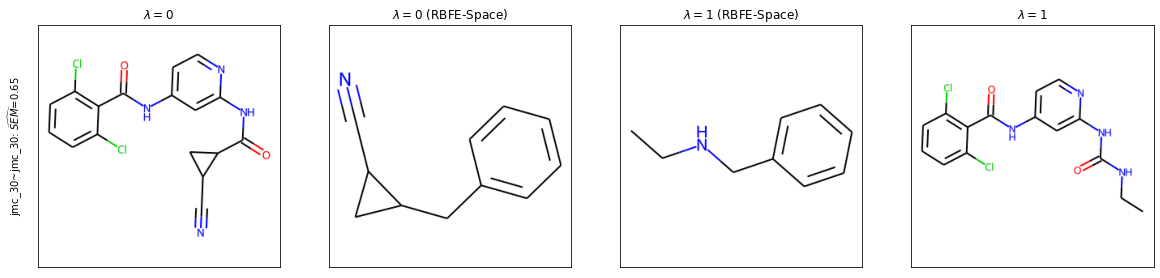

In [8]:
# an example method of looping through the data. Can also adjust this cell to show specific perts of course.
# let's plot the 'worst' five predicted transformations first.
n_to_show = 5
output_file_df = output_file_df.sort_values(by="sf_prediction", ascending=False)

for idx, row in output_file_df.head(n_to_show).iterrows(): 
    lig_1_path, lig_2_path, lig_1_smiles, lig_2_smiles, \
    lig_1_benzene_deri, lig_2_benzene_deriv, sf_prediction = row

    # create the perturbation name based on the file paths. 
    pert_name = f"{lig_1_path.split('/')[-1].replace('.sdf', '')}~{lig_1_path.split('/')[-1].replace('.sdf', '')}: $\widehat{{SEM}}$={round(sf_prediction, 2)}"

    # get the RDKit molecule objects for the 4 molecules.
    liga, ligb, ligc, ligd = [ Chem.MolFromSmiles(smi) for smi in \
                [lig_1_smiles, lig_1_benzene_deri, lig_2_benzene_deriv, lig_2_smiles] ]

    # align lambda endpoints for better depiction.
    liga, ligd = alignLigands(liga, ligd)
    
    # now plot this row.
    depictMolTriplet(liga, ligb, ligc, ligd, pert_name)
    

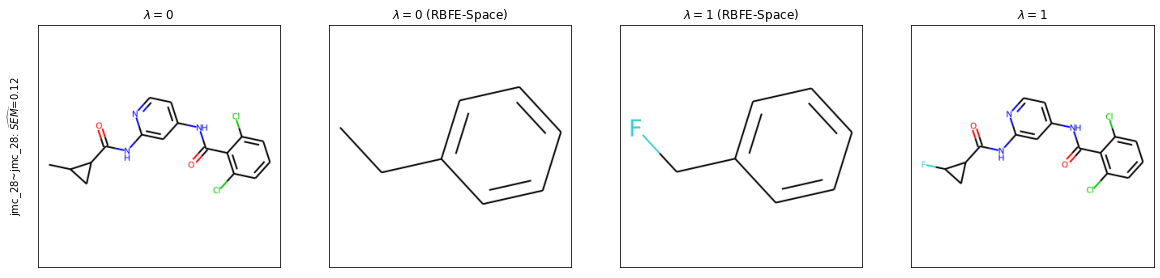

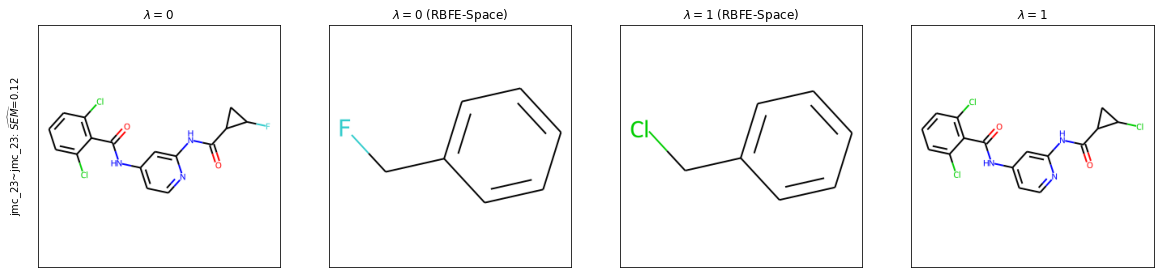

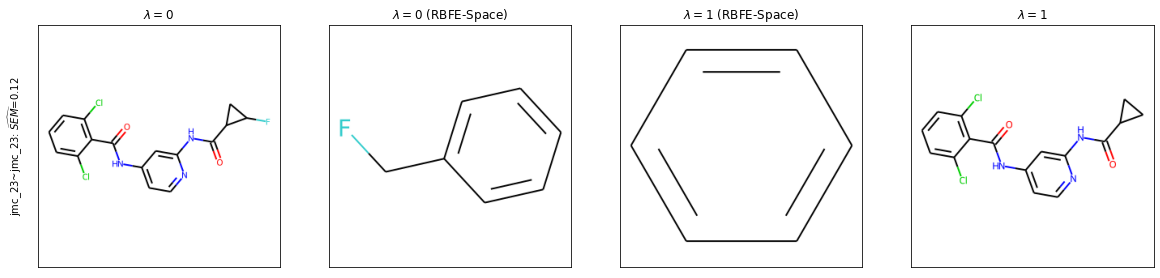

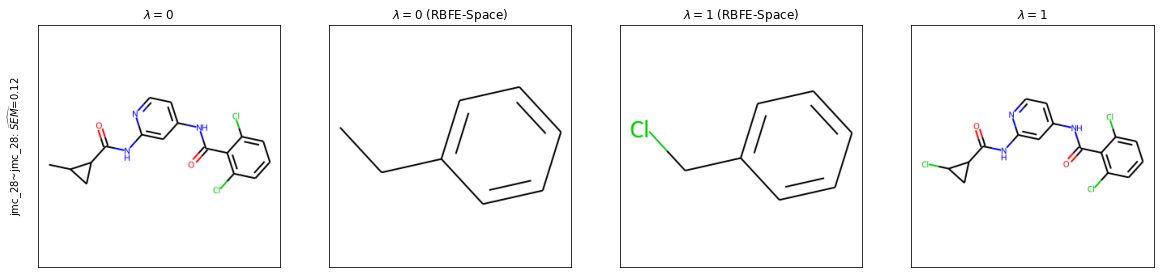

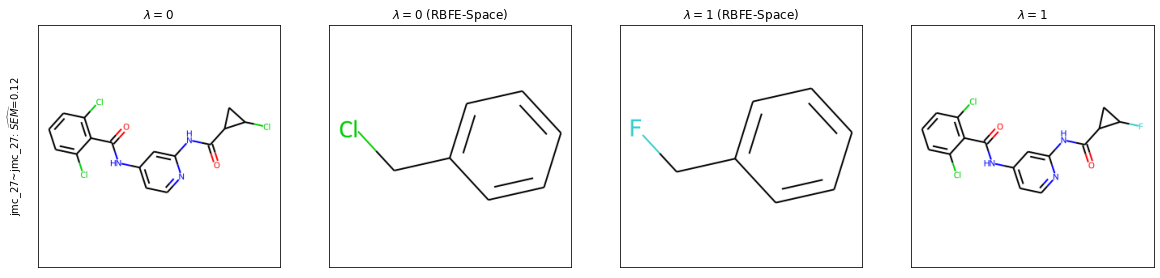

In [9]:
# let's plot the 'best' five predicted transformations next.
n_to_show = 5
output_file_df = output_file_df.sort_values(by="sf_prediction", ascending=True) # note the True flag.

for idx, row in output_file_df.head(n_to_show).iterrows(): 
    lig_1_path, lig_2_path, lig_1_smiles, lig_2_smiles, \
    lig_1_benzene_deri, lig_2_benzene_deriv, sf_prediction = row

    # create the perturbation name based on the file paths. 
    pert_name = f"{lig_1_path.split('/')[-1].replace('.sdf', '')}~{lig_1_path.split('/')[-1].replace('.sdf', '')}: $\widehat{{SEM}}$={round(sf_prediction, 2)}"

    # get the RDKit molecule objects for the 4 molecules.
    liga, ligb, ligc, ligd = [ Chem.MolFromSmiles(smi) for smi in \
                [lig_1_smiles, lig_1_benzene_deri, lig_2_benzene_deriv, lig_2_smiles] ]

    # align lambda endpoints for better depiction.
    liga, ligd = alignLigands(liga, ligd)
    
    # now plot this row.
    depictMolTriplet(liga, ligb, ligc, ligd, pert_name)

## Predicted SF vs. relative molecular weight

In [10]:
# we need to create lists of the values to plot to make sure that the points correspond.
rel_mol_weights = []
sf_preds = []

for idx, row in output_file_df.iterrows(): 
    lig_1_path, lig_2_path, lig_1_smiles, lig_2_smiles, \
    lig_1_benzene_deri, lig_2_benzene_deriv, sf_prediction = row
    
    # get the RDKit molecule objects for the 2 input molecules.
    liga, ligb, = [ Chem.MolFromSmiles(smi) for smi in \
                [lig_1_smiles, lig_2_smiles] ]
    
    # get the relative molecular weight.
    rel_mol_weight = Chem.rdMolDescriptors.CalcExactMolWt(ligb) - Chem.rdMolDescriptors.CalcExactMolWt(liga)
    
    # append values to lists.
    rel_mol_weights.append(rel_mol_weight)
    sf_preds.append(sf_prediction)

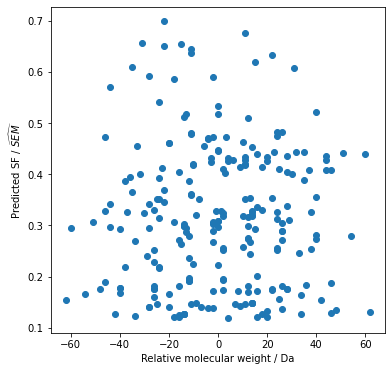

In [11]:
# use some simple plotting functions to display the correlation.
fig, ax = plt.subplots(figsize=(6, 6)) # easier for controlling figure dims
# NB: scatter plots always square!!


# make the histogram.
ax.scatter(rel_mol_weights, sf_preds)

# further formatting.
ax.set_xlabel("Relative molecular weight / Da")
ax.set_ylabel("Predicted SF / $\widehat{SEM}$")

plt.show()


Clearly not much correlation; could do some statistical analysis on this data but likely not useful. Regardless, we wouldn't expect there to be much correlation anyway (see paper discussion on RBFE-Space generation).

When working with error prediction sometimes it's helpful to plot/analyse data on logscale (see paper).

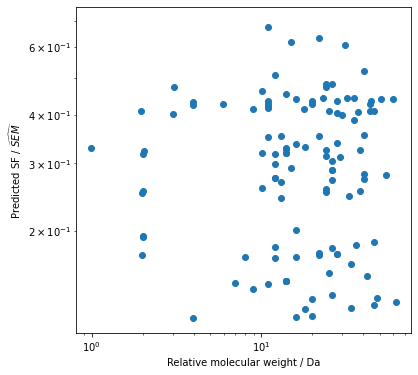

In [12]:
# use some simple plotting functions to display the correlation.
fig, ax = plt.subplots(figsize=(6, 6)) # easier for controlling figure dims
# NB: scatter plots always square!!


# make the histogram.
ax.scatter(rel_mol_weights, sf_preds)

ax.set_yscale('log')
ax.set_xscale('log')

# further formatting.
ax.set_xlabel("Relative molecular weight / Da")
ax.set_ylabel("Predicted SF / $\widehat{SEM}$")

plt.show()

In this case though it doesn't seem to be helpful. See paper SI for an example where it does help (i.e. error vs error). 